In [1]:
import tensorflow as tf
import cv2
import random
import numpy as np
from keras.backend import set_session

2023-02-22 16:37:34.969351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
set_session(session)

2023-02-22 16:37:39.871399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 16:37:40.115965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 16:37:40.161419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 16:37:40.161841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

In [3]:
class Config:
  TRAIN = True
  ROOT = "/mnt/c/Users/binarycat/YandexDisk/FishMl"
  #DATASET_PATH = ROOT + '/normal_behavior'
  # SINGLE_TEST_PATH = "/content/drive/My Drive/Colab Notebook2/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "data/model_encoder/model.hdf5"
  STEPS_PER_EPOCH=200
  NUM_FRAMES = 10
  NUM_SAMPLES = 20
  NUM_SELECTS = 2
  CLASSES = []

if Config.TRAIN:
  Config.CLASSES =  ['day', 'night']
else:
  Config.CLASSES =  ['object']

In [4]:
def format_frames(frame, output_size):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (256, 256))
        frame = frame.astype(np.float32)
        norm_frame = np.zeros((256, 256, 1))
        frame = cv2.normalize(frame, norm_frame, 0.0, 1.0, cv2.NORM_MINMAX)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = tf.image.convert_image_dtype(frame, tf.float32)
        frame = tf.image.resize_with_pad(frame, *output_size)
        return frame    

def frames_from_video_file (video_path, n_frames, output_size = (256,256), frame_step = 10):
        # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [0]]

    return result

def get_files_and_class_names(subsets, num_samples=Config.NUM_SAMPLES):
    video_paths = []
    classes = []
    for cls, files in subsets.items():
        files = files.copy()
        random.shuffle(files)     
        for f in files[:num_samples]:
            video_paths.append(f)
            classes.append(cls)
    return video_paths, classes    

class _FrameGenerator():
    def __init__(self, subsets, num_frames, num_selects=Config.NUM_SELECTS, training = False):
        self.subsets = subsets
        self.num_frames = num_frames
        self.training = training
        self.num_selects = num_selects

        self.class_names = subsets.keys()
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

        self.video_paths, _ = get_files_and_class_names(self.subsets)
        if self.training:
            random.shuffle(self.video_paths)     
        
        self.vid_index = 0
        self.pathes = []
    
    def __next__(self):
        if self.vid_index + self.num_selects >= len(self.video_paths):
            self.vid_index = 0
            random.shuffle(self.video_paths)     
            #raise StopIteration()

        clips = []
        self.pathes = []

        for i in range(self.num_selects):
            path = self.video_paths[self.vid_index + i]
            self.pathes.append(path)
            video_frames = frames_from_video_file(path, self.num_frames) 
            clips.append(video_frames)
        self.vid_index += self.num_selects

        clips = np.array(clips, ndmin=5)
        print(clips.shape)
        return clips, clips
    
    def last_pathes(self):
        return self.pathes
    
    def __iter__(self):
        return self


In [5]:
import collections
import os


class _PrepareSubsets():

    def __init__(self):

        self.classes = Config.CLASSES
        self.num_classes = len(self.classes)
        

    def get_files_per_class(self, root):
        files_for_class = collections.defaultdict(list)

        for class_dir in self.classes:
            for f in os.listdir(root + '/' + class_dir):
                full = root + '/' + class_dir + '/' + f

                # чтобы случайно не передали локальную директорию
                path = os.path.normpath(full)
                tokens = path.split(os.sep)
                if len(tokens) >= 2:
                    files_for_class[class_dir].append(full)

        return files_for_class

    def _select_subset_of_classes(files_for_class, classes, num_files_per_class):
        files_subset = dict()

        for class_name in classes:
            class_files = files_for_class[class_name]
            files_subset[class_name] = class_files[:num_files_per_class]

        return files_subset    

    def _split_class_lists(self, files_for_class, count):
        split_files = {}
        remainder = {}
        for cls in files_for_class:
            split_files[cls] = files_for_class[cls][:count]
            remainder[cls] = files_for_class[cls][count:]
        return split_files, remainder    

    def prepare_subsets(self, files_for_class, splits):
        for v in files_for_class.values():
            random.shuffle(v)

        # {название сплита: {имя класса: [список файлов]}}
        dirs = {}

        for split_name, split_count in splits.items():
            split_files, files_for_class = self._split_class_lists(files_for_class, split_count)
            # TODO скачивать с яндекс диска
            #download_from_zip(zip_url, split_dir, split_files)
            dirs[split_name] = split_files

        return dirs    


In [6]:
import keras
import numpy as np
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model

prep_subs = _PrepareSubsets()
files_for_classes = prep_subs.get_files_per_class(root =  Config.ROOT)
if Config.TRAIN:
    splits={"train": 20, "test": 0}
else:
    splits={"train": 0, "test": 20}

subsets = prep_subs.prepare_subsets(files_for_class=files_for_classes, splits=splits) 

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})    
    output_signature = (
        tf.TensorSpec(shape = (None, 256, 256, 1), dtype = tf.float32), 
        tf.TensorSpec(shape = (None, 256, 256, 1), dtype = tf.float32)
    )
 
    training_set = _FrameGenerator(subsets['train'], Config.NUM_FRAMES, training=True)
    #training_set = tf.data.Dataset.from_generator(training_set, output_signature = output_signature)
    #training_set = training_set.batch(batch_size=Config.BATCH_SIZE)
    # training_set = np.array(training_set)
    # print ("fghjk", training_set)
    # training_set = training_set.reshape(10,256,256,1)
    

    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False, steps_per_epoch=Config.STEPS_PER_EPOCH)
    seq.save(Config.MODEL_PATH)
    return seq


In [7]:
import matplotlib.pyplot as plt

def evaluate():
    model = get_model()
    print("got model")
    # test = get_single_test()
    # print(test.shape)
    # sz = test.shape[0] - 10 + 1
    # sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    # for i in range(0, sz):
    #     clip = np.zeros((10, 256, 256, 1))
    #     for j in range(0, 10):
    #         clip[j] = test[i + j, :, :, :]
    #     sequences[i] = clip

    # print("got data")
    # get the reconstruction cost of all the sequences
    # reconstructed_sequences = model.predict(sequences,batch_size=4)
    # sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    # sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    # sr = 1.0 - sa

    # plot the regularity scores
    # plt.plot(sr)
    # plt.ylabel('regularity score Sr(t)')
    # plt.xlabel('frame t')
    # plt.show()


In [8]:
#if Config.TRAIN:
#    evaluate()

2023-02-22 16:37:42.017068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 16:37:42.017542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 16:37:42.017797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 16:37:42.018432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-22 16:37:42.018921: I tensorflow/compile

(2, 10, 256, 256, 1)
(2, 10, 256, 256, 1)
(2, 10, 256, 256, 1)
(2, 10, 256, 256, 1)


2023-02-22 16:37:44.834794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/convolution_6' -> 'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/add_4', 'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/clip_by_value' -> 'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/mul_3', 'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/mul_2' -> 'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/add_5', 'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/clip_by_value_2' -> 'sequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/mul_5', 'sequential/conv_lstm2d_1/while/body/_49/sequential/conv_lstm2d_1/while/mul_2' -> 'sequential/conv_lstm2d_1/while/body/_49/sequential/conv_lstm2d_1/while/add_5', 'se

2/2 [==============================] - 10s 27ms/step


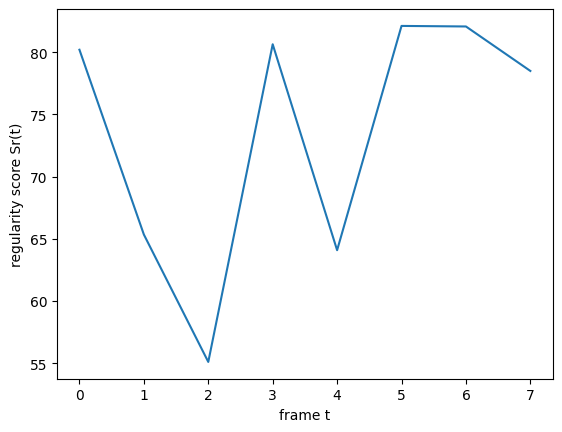

In [9]:
new_model = tf.keras.models.load_model(Config.MODEL_PATH)
if Config.TRAIN:
    subset = subsets['train']
else:
    subset = subsets['test']
test_set = _FrameGenerator(subset, Config.NUM_FRAMES, training=False)

seq = []
pathes = []
for i in range(4):
    seq.append(test_set.__next__()[0])
    pathes.extend(test_set.last_pathes())

seq = np.concatenate(seq, axis=0)
sz = seq.shape[0]
rec_seq = new_model.predict(seq, batch_size=4)

sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(seq[i], rec_seq[i])) for i in range(0,sz)])
#sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
#sr = 1.0 - sa
sr = sequences_reconstruction_cost

plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [10]:
for i, s in enumerate(sr):
    if s <= 0.5:
        print(i, pathes[i])

/mnt/c/Users/binarycat/YandexDisk/FishMl/day/IPCAM_2023-02-07-06-45-06.mp4


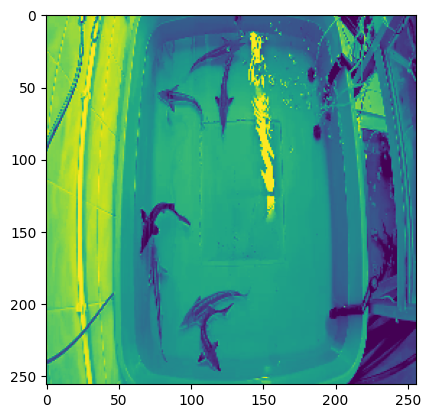

In [24]:
idx = 0
print(pathes[idx])
plt.imshow(seq[idx][0])

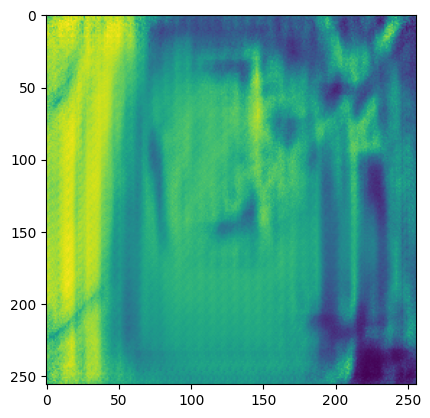

In [21]:
plt.imshow(rec_seq[idx][0])